**Install Pyspark**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a8f1b130524200713afb35ccf327f506784be7ffc2ff03f1bda2458ca2bec333
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**Import Library**

In [1]:
import pyspark

from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, LinearSVC, NaiveBayes, RandomForestClassifier, GBTClassifier
from pyspark.ml.linalg import Vectors


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import col
from pyspark.sql.functions import rand

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

spark = SparkSession.builder \
    .appName("RandomUndersamplingFraudDetection") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.rpc.message.maxSize", "2047") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

24/06/09 08:21:23 WARN Utils: Your hostname, Thais-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.0.104 instead (on interface en0)
24/06/09 08:21:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/09 08:21:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**Calculation confuse matrix**

In [2]:
def confusion_matrix(predictions, label_col="isFraud", prediction_col="prediction"):
    # Let's start by creating a DataFrame containing label and prediction
    df_confusion = predictions.select(label_col, prediction_col)

    # Now, let's crunch the numbers and compute the confusion matrix by grouping predictions by label and prediction
    confusion_matrix = df_confusion.groupBy(label_col) \
        .pivot(prediction_col, [str(i) for i in range(2)]) \
        .count() \
        .na.fill(0)

    # And finally, let's unveil the confusion matrix for all to see
    confusion_matrix.show()

**Evaluate model function**

In [3]:
def compute_metrics(predictions):
     # Let's start by evaluating the model with BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol="isFraud")

    # First, let's check out the AUC-ROC
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    # Extract values from the confusion matrix DataFrame
    TP = predictions.filter((col('isFraud') == 1) & (col('prediction') == 1)).count()
    TN = predictions.filter((col('isFraud') == 0) & (col('prediction') == 0)).count()
    FP = predictions.filter((col('isFraud') == 0) & (col('prediction') == 1)).count()
    FN = predictions.filter((col('isFraud') == 1) & (col('prediction') == 0)).count()

    # Compute accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Compute precision
    precision = TP / (TP + FP)

    # Compute recall
    recall = TP / (TP + FN)

    # Compute F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return auc_roc, accuracy, precision, recall, f1_score

**Read data using pyspark**

In [4]:
# Read data from csv file
df = spark.read.csv("/Users/thainguyenvu/Downloads/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)

In [6]:
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

**Convert type string to numerical format**

In [7]:
# Create a StringIndexer to convert the 'type' column to numerical format
string_indexer = StringIndexer(inputCol="type", outputCol="type_index")

# Train the StringIndexer on the data
string_indexer_model = string_indexer.fit(df)

# Apply the StringIndexer to transform the data
indexed_data = string_indexer_model.transform(df)

# Display the results
indexed_data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|       1.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|       1.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|       3.0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|       0.0|
|   1|

**Select and define feature columns that using to train model**

In [8]:
# Define feature columns
feature_cols = ['type_index', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_new = assembler.transform(indexed_data)
df_new.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|            features|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|       1.0|[1.0,9839.64,1701...|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|       1.0|[1.0,1864.28,2124...|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|       3.0|[3.0,181.0,181.0,...|
|   1|CASH_OUT|   181.

**Split data to 20% to test and 80% to train model**

In [9]:
train_df, test_df = df_new.randomSplit([0.8, 0.2], seed=123)

# Display number of rows data each train, test data
print("Number of rows in train dataset:", train_df.count())
print("Number of rows in test dataset:", test_df.count())

Number of rows in train dataset: 5089000


Number of rows in test dataset: 1273620


**Count number of fraud and not fraud in train dataset**

In [10]:
train_df.groupBy("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   6610|
|      0|5082390|
+-------+-------+



**Implement Random undersampling to handle imbalance data**

In [11]:
from pyspark.sql import functions as F

def undersample_majority(df, ratio=1):
    """
    Undersample the majority class in a Spark DataFrame to balance the dataset.

    Parameters:
    df (DataFrame): The input DataFrame containing the class column.
    ratio (int): The desired ratio of majority to minority class samples.
                 For example, a ratio of 1 means 1:1 balance between majority and minority classes.
                 A ratio of 5 means 5:1 balance (majority:minority).

    Returns:
    DataFrame: A DataFrame with the majority class undersampled to the specified ratio.
    """
    
    # Calculate the count of minority class samples
    minority_count = df.filter(F.col('isFraud') == 1).count()
    
    # Calculate the count of majority class samples
    majority_count = df.filter(F.col('isFraud') == 0).count()
    
    # Calculate the fraction of the majority class to sample
    sample_fraction = (ratio * minority_count) / majority_count
    
    # Undersample the majority class
    undersampled_majority = df.filter(F.col('isFraud') == 0)\
                              .sample(withReplacement=False, fraction=sample_fraction, seed=88)
    
    # Combine the minority class with the undersampled majority class
    undersampled_df = df.filter(F.col('isFraud') == 1).union(undersampled_majority)
    
    return undersampled_df

In [12]:
# Create new data frame balance data using undersampling
df_undersampling_1_1 = undersample_majority(train_df, 1)
df_undersampling_1_1.show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|            features|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|   1|CASH_OUT|     181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|       0.0|[0.0,181.0,181.0,...|
|   1|CASH_OUT|    2806.0|C2101527076|       2806.0|           0.0|C1007251739|       26202.0|           0.0|      1|             0|       0.0|[0.0,2806.0,2806....|
|   1|CASH_OUT|   20128.0|C1118430673|      20128.0|           0.0| C339924917|        6268.0|      12145.85|      1|             0|       0.0|[0.0,20128.0,2012...|
|   1|CASH

**Count number of value fraud and not fraud after applying Random Undersampling**

In [13]:
df_undersampling_1_1.groupBy("isFraud").count().show()

+-------+-----+
|isFraud|count|
+-------+-----+
|      1| 6610|
|      0| 6526|
+-------+-----+



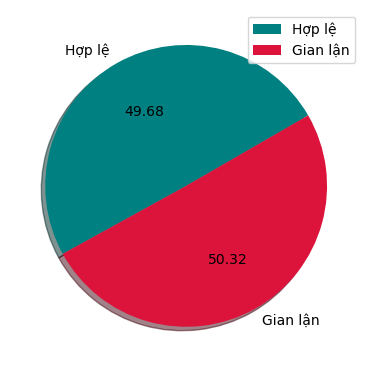

In [14]:
# Tạo biểu đồ cho số lượng và tỷ lệ phần trăm giao dịch gian lận so với Giao dịch hợp lệ
plt.figure(figsize=(10,5))

plt.subplot(122)
plt.pie(x=[6526,6610],labels=['Hợp lệ','Gian lận'],
        autopct='%.2f', colors=['#008080','crimson'], startangle=30, shadow=True)
plt.legend(loc='best')

plt.show()

# **TRAINNING MODEL**

**Define an array to save the value evaluation on the test data**

In [15]:
model_accuracy = []
model_precision = []
model_recall = []
model_f1 = []

**Define an array to save the value evaluation on the train data**

In [16]:
model_accuracy_train = []
model_precision_train = []
model_recall_train = []
model_f1_train = []

**Traning model using Decision Tree Classifier**
- Using three parameters:
    + maxDepth in [5, 10, 15]
    + maxBins in [20, 40, 60]
    + impurity in ["gini", "entropy"]
- Using 10-fold to cross validation

In [17]:
# Build model using Decision Tree
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [20, 30]) \
    .addGrid(dt.maxBins, [500, 1000]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_1)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())
print("Best Impurity:", best_model._java_obj.getImpurity())

Best Max Depth: 20
Best Max Bins: 1000
Best Impurity: entropy


In [18]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9972023008843964
Accuracy: 0.991096245347906
Precision: 0.12350166267110045
Recall: 0.9962570180910792
F1-score: 0.21976056144213568


In [19]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_1)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


**Traning model using Support Vector Machine**
- Using two parameters:
  + maxIter in [10, 100]
  + regParam in [0.1, 0.01]
- Using 10-fold to cross validation

In [20]:
# Build model Support Vector Machine
svm = LinearSVC(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 100]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_1)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Iterations:", best_model._java_obj.getMaxIter())

24/06/09 08:31:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/09 08:31:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Best Max Iterations: 100


In [21]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9475900494275488
Accuracy: 0.9777099919913318
Precision: 0.04377299359585775
Recall: 0.801621958827199
F1-score: 0.08301301721631836


In [22]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_1)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9437904497452991
Accuracy: 0.8848964677222899
Precision: 0.9752050708426547
Recall: 0.791376701966717
F1-score: 0.8737264072156338


**Traning model using Naive Bayes**
- Using two parameters:
  + smoothing in [0.1, 0.5, 1.0]
- Using 10-fold to cross validation

In [26]:
# Build model Naive Bayes
nb = NaiveBayes(labelCol="isFraud", featuresCol="features")

# Define parameter grid (smoothing parameter)
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.1, 0.5, 1.0]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_1)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Smoothing Parameter:", best_model._java_obj.getSmoothing())

Best Smoothing Parameter: 0.1


In [27]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.43775134664860527
Accuracy: 0.6267316782085709
Precision: 0.00287072303188643
Recall: 0.8533998752339363
F1-score: 0.0057221973572483265


In [28]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_1)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.4372446673216363
Accuracy: 0.738733252131547
Precision: 0.6944920440636475
Recall: 0.8583963691376701
F1-score: 0.7677943166441137


**Traning model using Logistic Regression**
- Using two parameters:
  + regParam in [0.1, 0.01]
  + elasticNetParam in [0.0, 0.5, 1.0]
  + maxIter in [10, 100]
- Using 10-fold to cross validation

In [29]:
# Build model Logistic Regression
lr = LogisticRegression(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 100]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_1)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Elastic Net Parameter:", best_model._java_obj.getElasticNetParam())
print("Best Max Iterations:", best_model._java_obj.getMaxIter())

Best Elastic Net Parameter: 1.0
Best Max Iterations: 100


In [30]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9717765265784449
Accuracy: 0.9641031076773292
Precision: 0.030141013078856558
Recall: 0.8827199001871491
F1-score: 0.058291622896455134


In [31]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_1)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9712274259183447
Accuracy: 0.9174786845310596
Precision: 0.9618856569709128
Recall: 0.8704992435703479
F1-score: 0.9139135959339263


**Traning model using Random Forest**
- Using two parameters:
  + maxDepth in [20, 30]
  + maxBins in [500, 1000]
- Using 10-fold to cross validation

In [32]:
# Build model Random Forest
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [20, 30]) \
    .addGrid(rf.maxBins, [500, 1000]) \
    .build()


# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_1)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())

Best Max Depth: 30
Best Max Bins: 500


In [33]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9984841944875449
Accuracy: 0.9903676135739075
Precision: 0.1152874972945675
Recall: 0.9968808484092326
F1-score: 0.2066735644076565


In [34]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_1)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9999990031726927
Accuracy: 0.9993909866017052
Precision: 0.9993948562783661
Recall: 0.9993948562783661
F1-score: 0.9993948562783661


**Traning model using Gradient Boosting Trees**
- Using two parameters:
  + maxDepth in [20, 30]
  + maxBins in [500, 1000]
- Using 10-fold to cross validation

In [35]:
# Build model Gradient Boosting Tree
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [20, 30]) \
    .addGrid(gbt.maxBins, [500, 1000]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(df_undersampling_1_1)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())

Best Max Depth: 20
Best Max Bins: 1000


In [36]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9952456898620243
Accuracy: 0.9910452097171841
Precision: 0.12270977675134719
Recall: 0.9943855271366189
F1-score: 0.21846090591379427


In [37]:
# Predict on the train dataset
predictions = best_model.transform(df_undersampling_1_1)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


# **Summarize the result**

**1. Result on the test dataset**

In [38]:
# Result on the test dataset
name = ["Decision Tree", "Support Vector Machine","Naive Bayes", "Logistic Regression","Random Forest", "Gradient Boosting Trees"]
model = pd.DataFrame(data=[name,
                   model_accuracy,
                   model_precision,
                   model_recall,
                   model_f1]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-score']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-score
0,Decision Tree,0.991096,0.123502,0.996257,0.219761
1,Support Vector Machine,0.97771,0.043773,0.801622,0.083013
2,Naive Bayes,0.626732,0.002871,0.8534,0.005722
3,Logistic Regression,0.964103,0.030141,0.88272,0.058292
4,Random Forest,0.990368,0.115287,0.996881,0.206674
5,Gradient Boosting Trees,0.991045,0.12271,0.994386,0.218461


**2. Result on the train dataset**

In [39]:
# Result on the train dataset
name = ["Decision Tree", "Support Vector Machine","Naive Bayes", "Logistic Regression","Random Forest", "Gradient Boosting Trees"]
model = pd.DataFrame(data=[name,
                   model_accuracy_train,
                   model_precision_train,
                   model_recall_train,
                   model_f1_train]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-socre']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-socre
0,Decision Tree,1.0,1.0,1.0,1.0
1,Support Vector Machine,0.884896,0.975205,0.791377,0.873726
2,Naive Bayes,0.738733,0.694492,0.858396,0.767794
3,Logistic Regression,0.917479,0.961886,0.870499,0.913914
4,Random Forest,0.999391,0.999395,0.999395,0.999395
5,Gradient Boosting Trees,1.0,1.0,1.0,1.0
